# Audio

## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

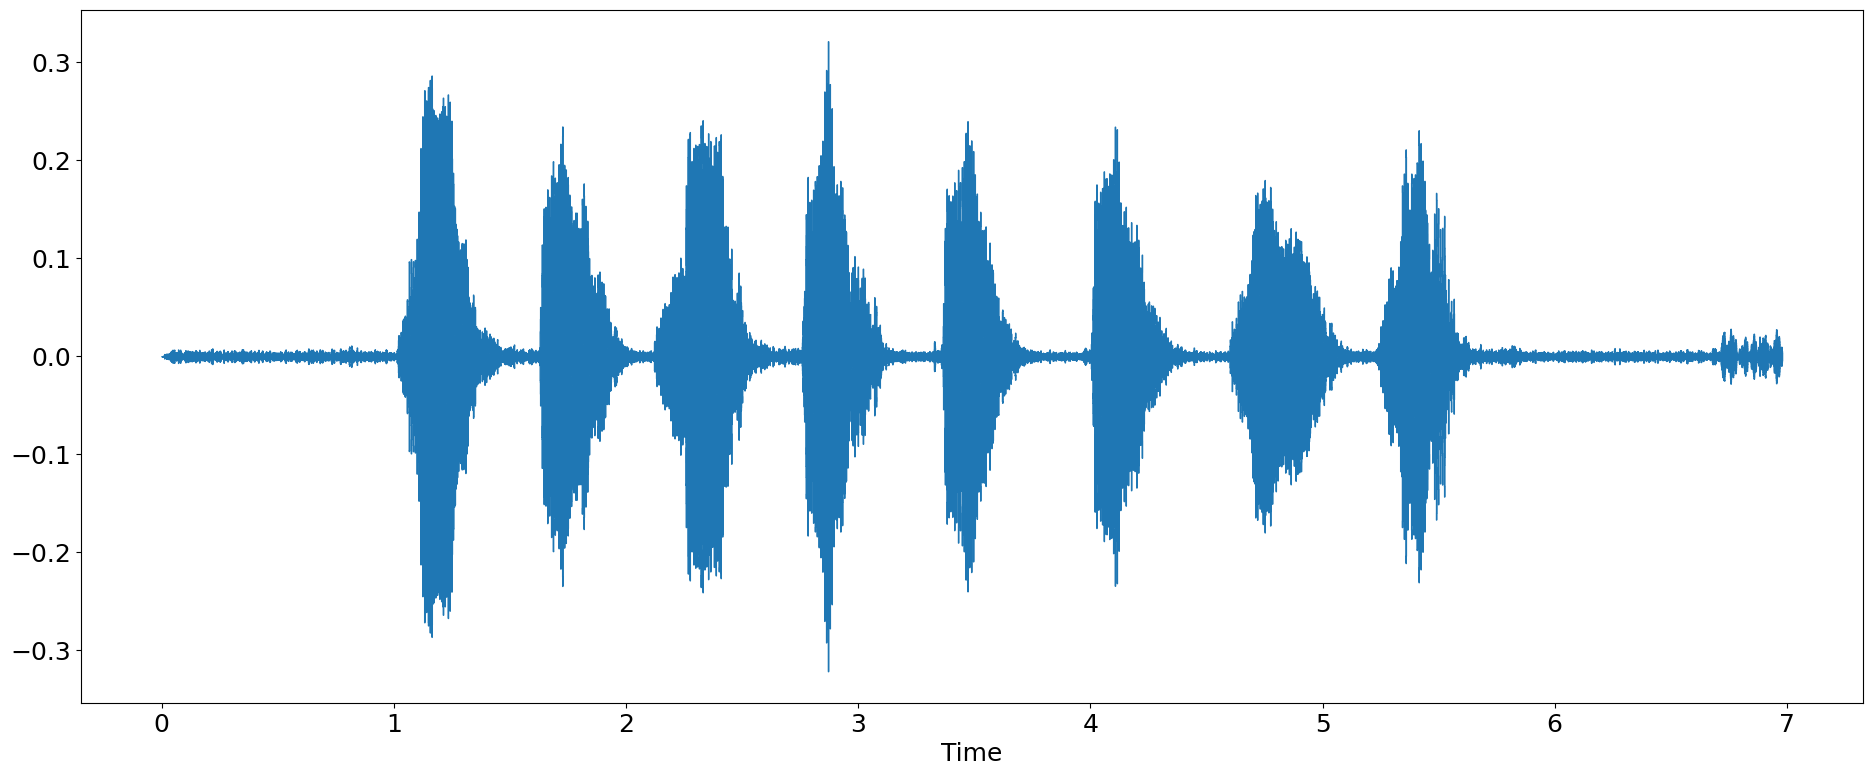

In [98]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from IPython.display import Audio

y, sr = librosa.load('../data-samples/waves_yesno/0_1_0_1_1_1_0_0.wav', duration=10)
plt.figure(figsize=(23, 9))
librosa.display.waveshow(y, sr=sr)
Audio(data=y, rate=sr)

## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) 
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

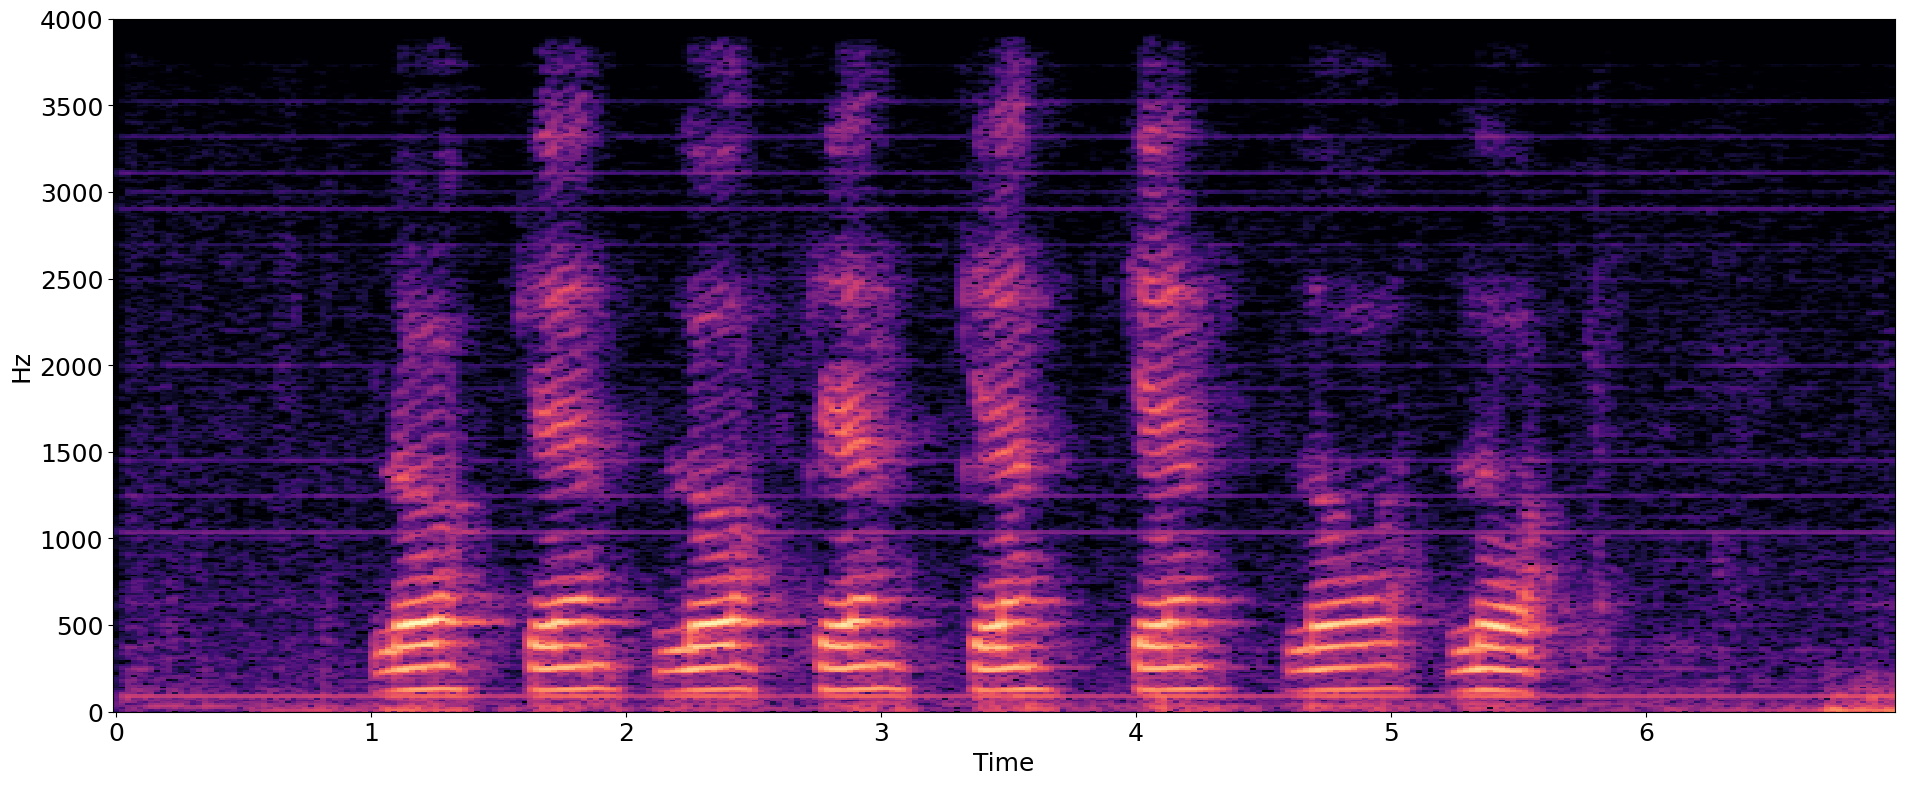

In [100]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)))
fig, ax = plt.subplots(figsize=(23, 9))
ax.set_ylim([0, 4000])
plt.rcParams['font.size'] = 18
ax = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr)

## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

In [240]:
def load_dataset(directory: str):
    sr = None
    X, labels, files = [], [], []
    for f in glob.glob(directory + "/*.wav"):
        filename = os.path.basename(f)
        name = filename[:-4]
        y = [int(label) for label in name.split("_")]
        x, sr = librosa.load(f, sr=16000)
        X.append(x)
        labels.append(y)
        files.append(filename)
    return X, labels, sr, files

In [241]:
from sklearn.model_selection import train_test_split

X, labels, sr, files = load_dataset('../data-samples/waves_yesno/')
train_X, test_X, train_labels, test_labels = train_test_split(X, labels, test_size=0.2, random_state=42)
print("train=%d, test=%d" % (len(train_X), len(test_X)))

train=47, test=12


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи, 
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]] 
![sftp](../misc/images/vad.png)

Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

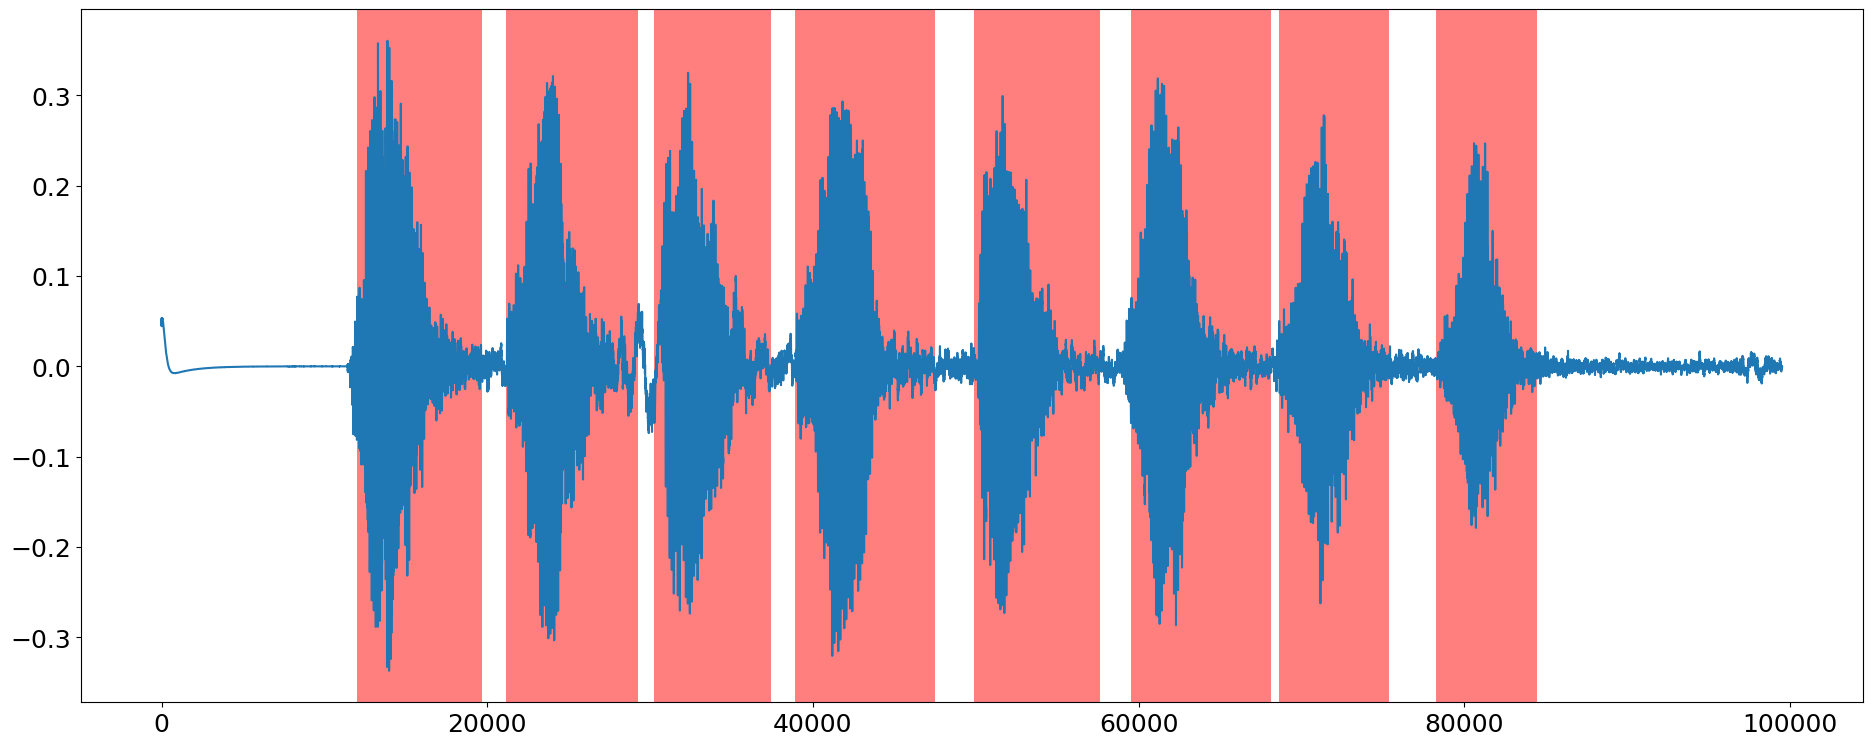

In [313]:
import struct
import webrtcvad

def get_vad_segments(y):
    if y.dtype.kind == 'f':
        y = np.array([ int(s * 8000) for s in y])
    raw_samples = struct.pack("%dh" % len(y), *y)

    vad = webrtcvad.Vad(3)
    window_duration = 0.03
    samples_per_window = int(window_duration * sr + 0.5)
    bytes_per_sample = 2

    segments = []
    for i, start in enumerate(np.arange(0, len(y), samples_per_window)):
        stop = min(start + samples_per_window, len(y))
        loc_raw_sample = raw_samples[start * bytes_per_sample: stop * bytes_per_sample]
        try:
            is_speech = vad.is_speech(loc_raw_sample, sample_rate = sr)
            
            if is_speech:
                if len(segments) == 0:
                    segments.append([start, stop])
                else:
                    if segments[-1][1] == start:
                        segments[-1][1] = stop
                    else:
                        segments.append([start, stop])        
        except Exception as e:
            print(f"Failed for step {i}, reason: {e}")
    while len(segments) > 8:
        sub = (x[1] - x[0] for x in segments)
        index_min = np.argmin(sub)
        del segments[index_min]


    return segments

y, sr = librosa.load('../data-samples/waves_yesno/0_0_1_0_1_0_0_0.wav', sr=16000)
segments = get_vad_segments(y)

fig, ax = plt.subplots(1, figsize=(23, 9))
ax.plot(y)
for seg in segments:
    ax.axvspan(seg[0], seg[1], facecolor='red', alpha=0.5)


## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

In [303]:
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))
            X.append(stft_db)  # Добавляем спектрограмму с речью
            try:                
                y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы    
            except Exception as e:
                print(f"Failed for sample {sample}, segment {segment}, labels {labels[sample]} reason: {e}")
            
    return np.array(X), np.array(y)

In [314]:
train_vad = []
for t in train_X:
    train_vad.append(get_vad_segments(t))

test_vad = []
for t in test_X:
    test_vad.append(get_vad_segments(t))

X_train, Y_train = make_dataset(train_X, train_labels, train_vad)
X_test, Y_test = make_dataset(test_X, test_labels, test_vad)

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = svm.SVC()
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
ac_svm = accuracy_score(Y_test, pred)

clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
pred = clf.predict(X_test)
ac_lr = accuracy_score(Y_test, pred)

print(f"Accuracy SVM={ac_svm}, LogisticRegression={ac_lr}")

Accuracy SVM=1.0, LogisticRegression=1.0
